# Forecast with additive regression via Facebook Prophet

## Introduction

In this notebook, I approach forecasting with additive regression approach using the Facebook Prophet forecasting tool (FB Prophet).

I start with the San Juan data and tune a few FB Prophet parameters.  

Then, I apply the most-successful approach to the Iquitos data.

Finally, I put my comments at the end.

## Set up

In [1]:
# Eliminate some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import global libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

# Import converters to allow matplotlib to use dates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Set some Seaborn defaults
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('muted')

In [3]:
# Import homegrown functions
import my_func
import importlib  

In [4]:
# Import notebook-specific libraries
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# First, need to install fbprophet via conda
# conda install -c conda-forge fbprophet.
# There are conflicts with calendars and easter, so I roll back a calendar package.

from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## Load data

In [5]:
# Load testing and training data
test_sj = pd.read_pickle('../sb_cap2_nb-99_data/prep_test_sj.pickle')
train_sj = pd.read_pickle('../sb_cap2_nb-99_data/prep_train_sj.pickle')
test_iq = pd.read_pickle('../sb_cap2_nb-99_data/prep_test_iq.pickle')
train_iq = pd.read_pickle('../sb_cap2_nb-99_data/prep_train_iq.pickle')

# Load testing and training data - log tranformed
log_test_sj = pd.read_pickle('../sb_cap2_nb-99_data/prep_log_test_sj.pickle')
log_train_sj = pd.read_pickle('../sb_cap2_nb-99_data/prep_log_train_sj.pickle')
log_test_iq = pd.read_pickle('../sb_cap2_nb-99_data/prep_log_test_iq.pickle')
log_train_iq = pd.read_pickle('../sb_cap2_nb-99_data/prep_log_train_iq.pickle')

# Load scores
score_df = pd.read_pickle('../sb_cap2_nb-99_data/scores_after_nbk_7.pickle')

## Define functions

In [6]:
def prep_for_prophet(df):
    """Prepare dataframe as Prophet is expecting"""
    
    # Move date from index to column
    prep_df = df.copy()
    prep_df.reset_index(inplace=True)
#     Prep_df['total_cases'].astype('float64')
    
    # Rename columns
    prep_df.rename(columns = {'week_start_date':'ds', 'total_cases':'y'}, inplace = True)
    
    return prep_df

In [7]:
def combine_actual_and_prophet_forecast_into_single_df(actual, prophet):
    
    forecast_values = list(prophet['yhat'].tail(len(actual)))
    actual_df = actual.copy()
    actual_df['forecast'] = forecast_values
    actual_df.columns = ['actual', 'forecast']

    return actual_df

## Variation 1 - Baseline - San Juan

In [8]:
this_run_train = train_sj
this_run_test = test_sj
this_run_details = 'default'
this_run_city = 'san juan'
this_run_data_set = 'test'

this_run_approach = 'additive'
this_run_variation = 1
this_run_transform = 'none'

In [9]:
# Prep data
this_run_train_p_ready = prep_for_prophet(this_run_train)

In [10]:
# Instantiate
model = Prophet(weekly_seasonality=False, daily_seasonality=False)

In [11]:
# Fit
fit = model.fit(this_run_train_p_ready)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [12]:
# Summarize model
pass

In [13]:
# Forecast
forc_periods  = len(this_run_test)
forc_df_frame = model.make_future_dataframe(freq='W', periods=forc_periods)
forc = model.predict(forc_df_frame)

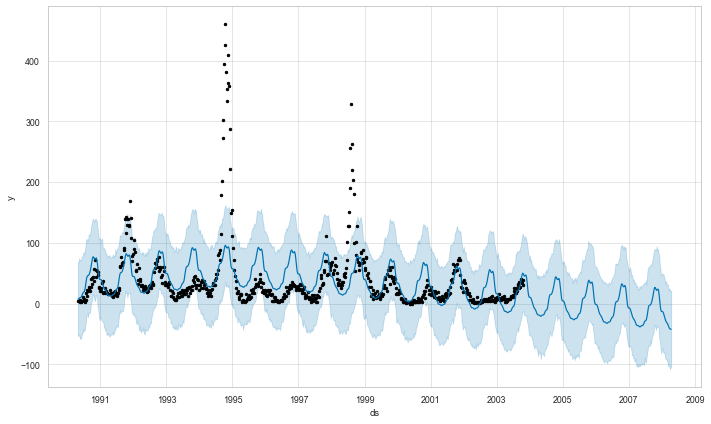

In [14]:
# Graph entire series
model.plot(forc);
# NOTE:  I need the ; after the statement to stop Jupyter from displaying doubles of each plot

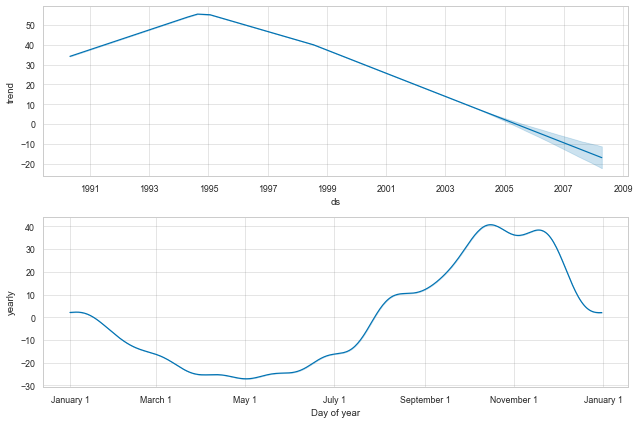

In [15]:
# Graph components
model.plot_components(forc);

In [16]:
# Clean 
clean = combine_actual_and_prophet_forecast_into_single_df(this_run_test, forc)

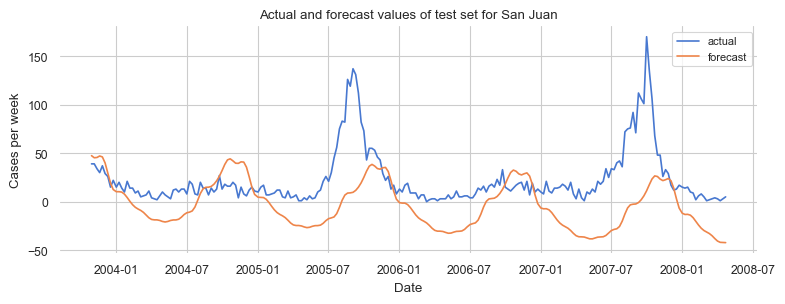

In [17]:
# Graph
my_func.graph_actual_and_forecast_from_test(clean, str.title(this_run_city))

In [18]:
# Summarize forecast
clean['forecast'].describe().apply(lambda x: format(x, 'f'))

count    234.000000
mean      -3.615436
std       23.807427
min      -42.158010
25%      -23.820909
50%       -7.411117
75%       14.593821
max       47.426026
Name: forecast, dtype: object

In [19]:
# Score
my_func.score(this_run_approach, this_run_variation, 
              this_run_details, this_run_city, this_run_data_set, this_run_transform, 
              clean['actual'], clean['forecast'], score_df)

In [20]:
# Review scores - San Juan
score_df.tail(1)

,approach,variation,summary,city,data,transform,rmse,mae
28,additive,1,default,san juan,test,none,40.390939,30.960815


## Variation 2 - stabilized trend  - San Juan

In [21]:
this_run_train = train_sj
this_run_test = test_sj
this_run_details = 'stabilized trend'
this_run_city = 'san juan'
this_run_data_set = 'test'

this_run_approach = 'additive'
this_run_variation = 2
this_run_transform = 'none'

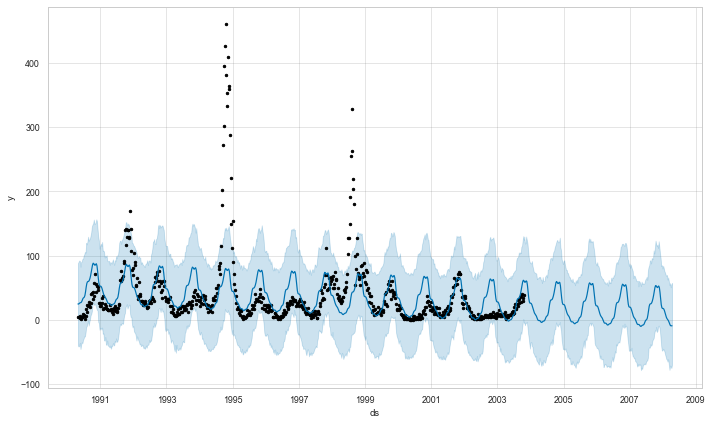

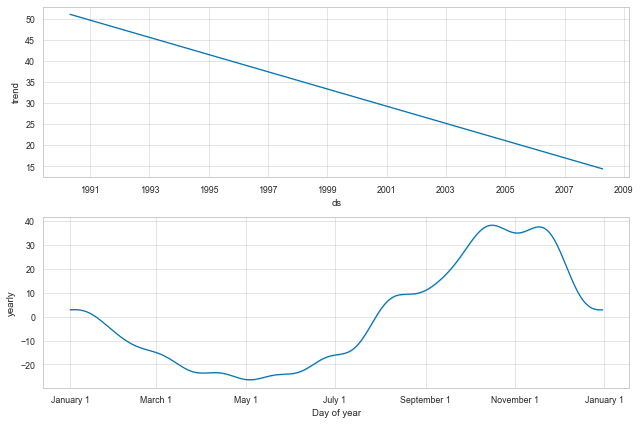

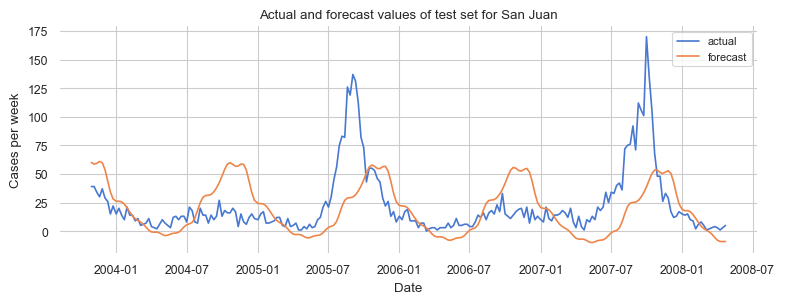

In [22]:
this_run_train_p_ready = prep_for_prophet(this_run_train)

# Reduce "flexibilty" of changepoints from default of .05
# Reduce the number of changepoints from default of (25)
model = Prophet(weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=.0025, n_changepoints=10)

fit = model.fit(this_run_train_p_ready)

forc_periods  = len(this_run_test)

forc_df_frame = model.make_future_dataframe(freq='W', periods=forc_periods)

forc = model.predict(forc_df_frame)

model.plot(forc);

model.plot_components(forc);

clean = combine_actual_and_prophet_forecast_into_single_df(this_run_test, forc)

my_func.graph_actual_and_forecast_from_test(clean, str.title(this_run_city))

my_func.score(this_run_approach, this_run_variation, 
              this_run_details, this_run_city, this_run_data_set, this_run_transform, 
              clean['actual'], clean['forecast'], score_df)

In [23]:
score_df.tail(1)

,approach,variation,summary,city,data,transform,rmse,mae
29,additive,2,stabilized trend,san juan,test,none,29.200444,20.051671


## Variation 3 - cap & floor - San Juan

In [24]:
this_run_train = train_sj
this_run_test = test_sj
this_run_details = 'cap and floor'
this_run_city = 'san juan'
this_run_data_set = 'test'

this_run_approach = 'additive'
this_run_variation = 3
this_run_transform = 'none'

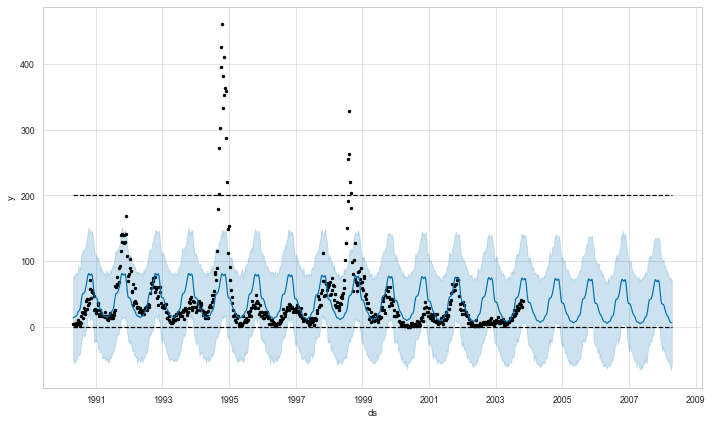

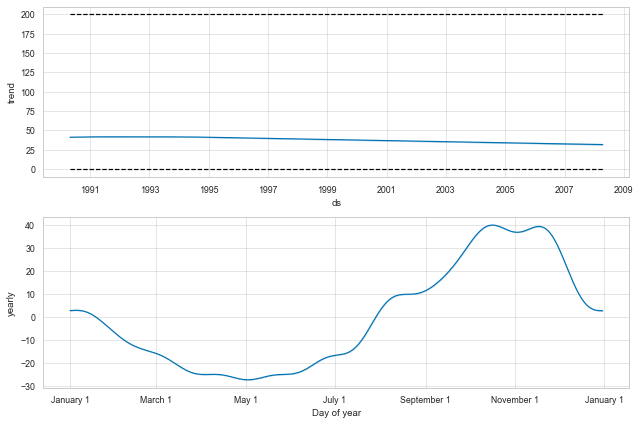

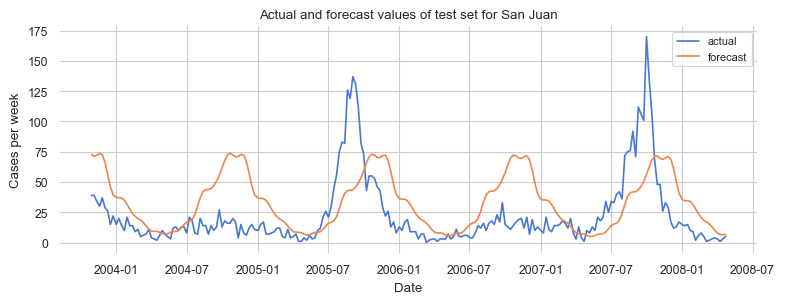

In [25]:
this_run_train_p_ready = prep_for_prophet(this_run_train)

# Add a cap and floor to training
this_run_train_p_ready['cap'] = 200
this_run_train_p_ready['floor'] = 0

# Tune growth model
model = Prophet(weekly_seasonality=False, daily_seasonality=False, growth='logistic') 

fit = model.fit(this_run_train_p_ready)

forc_periods  = len(this_run_test)

forc_df_frame = model.make_future_dataframe(freq='W', periods=forc_periods)

# Add cap and floor to forecast dataframe
forc_df_frame['cap'] = 200
forc_df_frame['floor'] = 0

forc = model.predict(forc_df_frame)

model.plot(forc);

model.plot_components(forc);

clean = combine_actual_and_prophet_forecast_into_single_df(this_run_test, forc)

my_func.graph_actual_and_forecast_from_test(clean, str.title(this_run_city))

my_func.score(this_run_approach, this_run_variation, 
              this_run_details, this_run_city, this_run_data_set, this_run_transform, 
              clean['actual'], clean['forecast'], score_df)

In [26]:
score_df.tail(1)

,approach,variation,summary,city,data,transform,rmse,mae
30,additive,3,cap and floor,san juan,test,none,30.865402,23.434221


## Variation 4 - stabillized trend - log data - San Juan

In [27]:
this_run_train = log_train_sj
this_run_test = log_test_sj
this_run_details = 'stabilized trend'
this_run_city = 'san juan'
this_run_data_set = 'test'

this_run_approach = 'additive'
this_run_variation = 4
this_run_transform = 'log(x+1)'

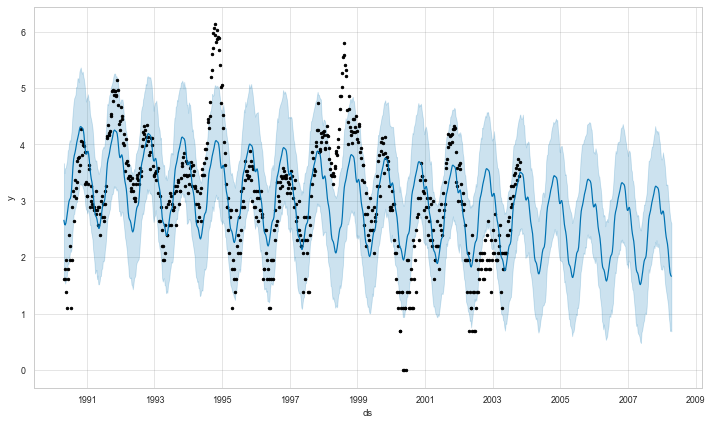

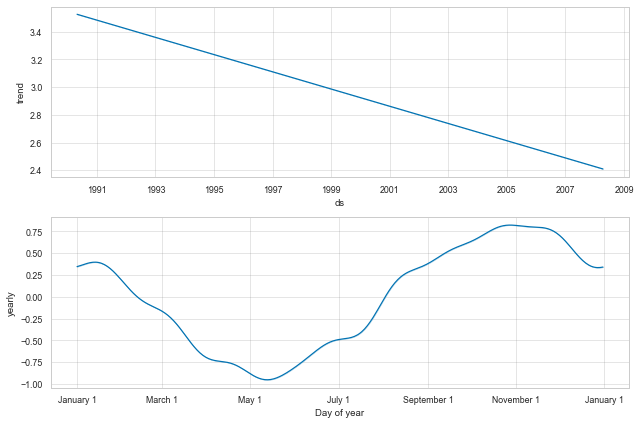

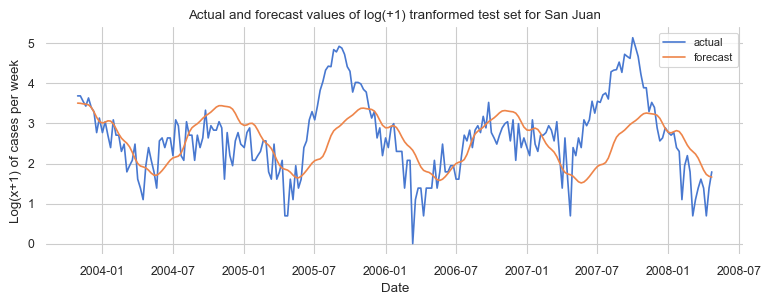

In [28]:
this_run_train_p_ready = prep_for_prophet(this_run_train)


model = Prophet(weekly_seasonality=False, daily_seasonality=False, 
                changepoint_prior_scale=.0025, n_changepoints=10)

fit = model.fit(this_run_train_p_ready)

forc_periods  = len(this_run_test)

forc_df_frame = model.make_future_dataframe(freq='W', periods=forc_periods)

forc = model.predict(forc_df_frame)

model.plot(forc);

model.plot_components(forc);

clean = combine_actual_and_prophet_forecast_into_single_df(this_run_test, forc)

# Graph for log data
my_func.graph_actual_and_forecast_from_test_for_log_data(clean, str.title(this_run_city)) 

In [29]:
clean = my_func.tranform_back_from_log_x_plus_1(clean)

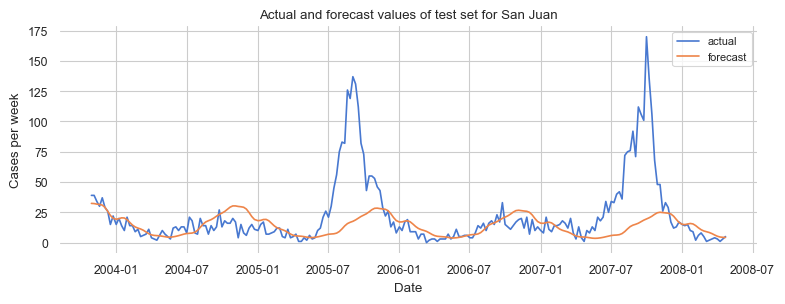

In [30]:
# Graph with back-transformed data
my_func.graph_actual_and_forecast_from_test(clean, str.title(this_run_city)) 

In [31]:
my_func.score(this_run_approach, this_run_variation, 
              this_run_details, this_run_city, this_run_data_set, this_run_transform, 
              clean['actual'], clean['forecast'], score_df)

In [32]:
score_df.tail(1)

,approach,variation,summary,city,data,transform,rmse,mae
31,additive,4,stabilized trend,san juan,test,log(x+1),28.704714,14.594313


## Variation 5 - cap & floor - log data - San Juan

In [33]:
this_run_train = log_train_sj
this_run_test = log_test_sj
this_run_details = 'cap and floor'
this_run_city = 'san juan'
this_run_data_set = 'test'

this_run_approach = 'additive'
this_run_variation = 5
this_run_transform = 'log(x+1)'

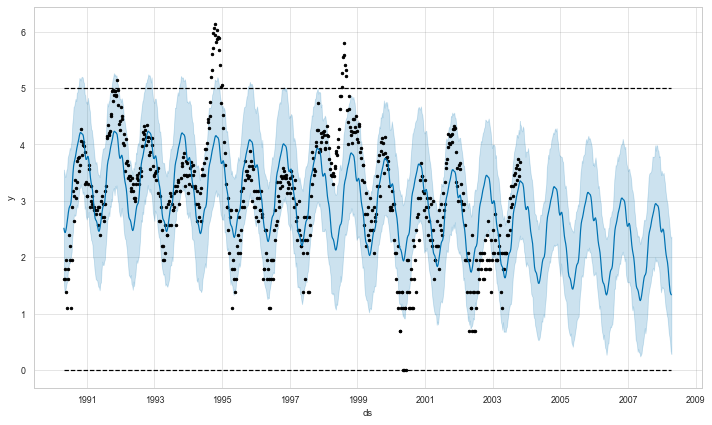

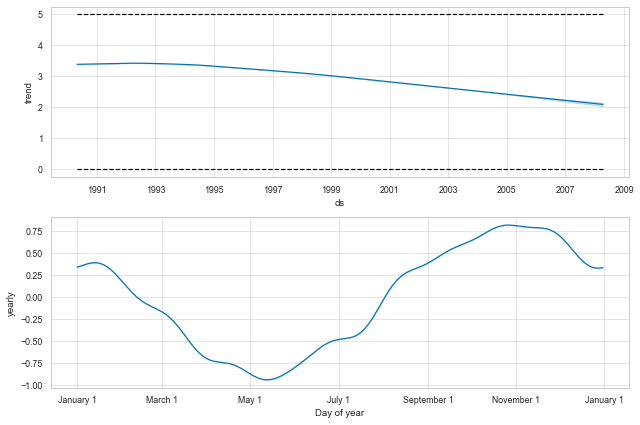

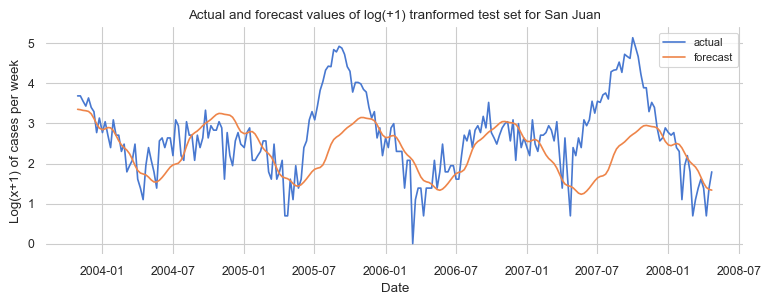

In [34]:
this_run_train_p_ready = prep_for_prophet(this_run_train)

# Add a cap and floor to training
this_run_train_p_ready['cap'] = 5
this_run_train_p_ready['floor'] = 0

# Tune growth model
model = Prophet(weekly_seasonality=False, daily_seasonality=False, growth='logistic') 

fit = model.fit(this_run_train_p_ready)

forc_periods  = len(this_run_test)

forc_df_frame = model.make_future_dataframe(freq='W', periods=forc_periods)

# Add cap and floor to forecast dataframe
forc_df_frame['cap'] = 5
forc_df_frame['floor'] = 0

forc = model.predict(forc_df_frame)

model.plot(forc);

model.plot_components(forc);

clean = combine_actual_and_prophet_forecast_into_single_df(this_run_test, forc)

# Graph for log data
my_func.graph_actual_and_forecast_from_test_for_log_data(clean, str.title(this_run_city)) 

In [35]:
clean = my_func.tranform_back_from_log_x_plus_1(clean)

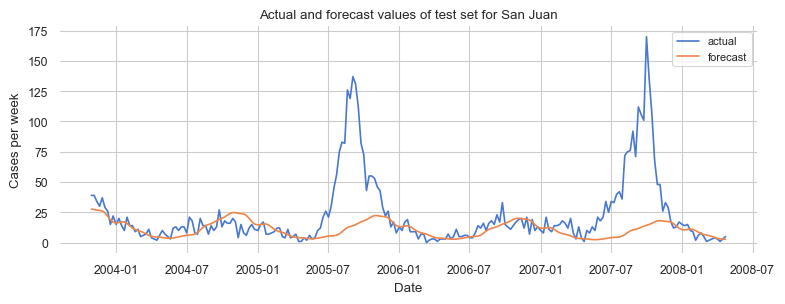

In [36]:
# Graph with back-transformed data
my_func.graph_actual_and_forecast_from_test(clean, str.title(this_run_city))

In [37]:
my_func.score(this_run_approach, this_run_variation, 
              this_run_details, this_run_city, this_run_data_set, this_run_transform, 
              clean['actual'], clean['forecast'], score_df)

In [38]:
score_df.tail(1)

,approach,variation,summary,city,data,transform,rmse,mae
32,additive,5,cap and floor,san juan,test,log(x+1),29.944419,14.636217


## Summarize - all models from this notebook - San Juan

In [39]:
score_df[(score_df['approach'] == 'additive') &  (score_df['city'] == 'san juan')].sort_values('mae')

,approach,variation,summary,city,data,transform,rmse,mae
31,additive,4,stabilized trend,san juan,test,log(x+1),28.704714,14.594313
32,additive,5,cap and floor,san juan,test,log(x+1),29.944419,14.636217
29,additive,2,stabilized trend,san juan,test,none,29.200444,20.051671
30,additive,3,cap and floor,san juan,test,none,30.865402,23.434221
28,additive,1,default,san juan,test,none,40.390939,30.960815


## Variation 6 - stabilized trend - log data - Iquitos

In [40]:
this_run_train = log_train_iq
this_run_test = log_test_iq
this_run_details = 'stabilized trend'
this_run_city = 'iquitos'
this_run_data_set = 'test'

this_run_approach = 'additive'
this_run_variation = 6
this_run_transform = 'log(x+1)'

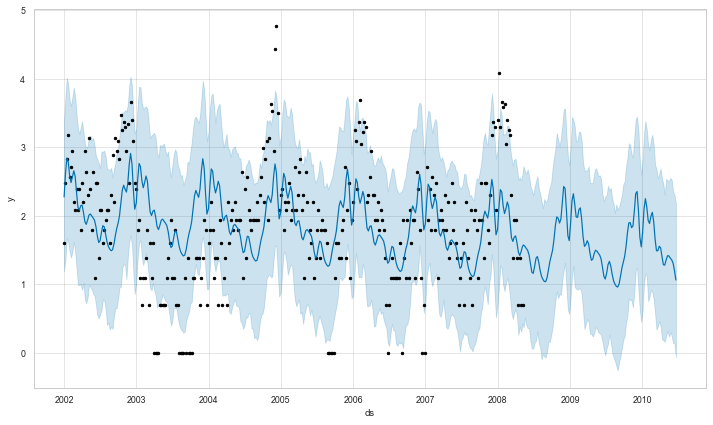

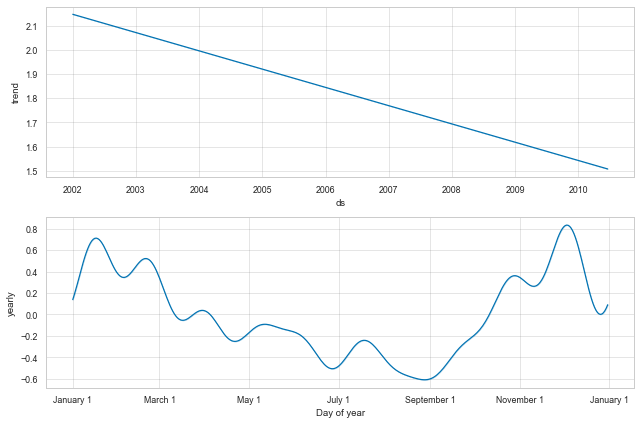

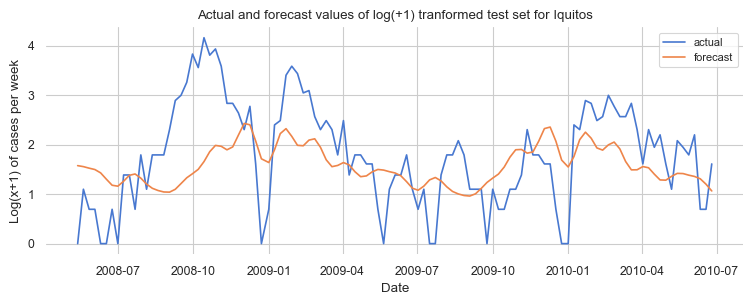

In [41]:
this_run_train_p_ready = prep_for_prophet(this_run_train)

model = Prophet(weekly_seasonality=False, daily_seasonality=False, 
                changepoint_prior_scale=.0025, n_changepoints=10)

fit = model.fit(this_run_train_p_ready)

forc_periods  = len(this_run_test)

forc_df_frame = model.make_future_dataframe(freq='W', periods=forc_periods)

forc = model.predict(forc_df_frame)

model.plot(forc);

model.plot_components(forc);

clean = combine_actual_and_prophet_forecast_into_single_df(this_run_test, forc)

# Graph for log data
my_func.graph_actual_and_forecast_from_test_for_log_data(clean, str.title(this_run_city))

In [42]:
clean = my_func.tranform_back_from_log_x_plus_1(clean)

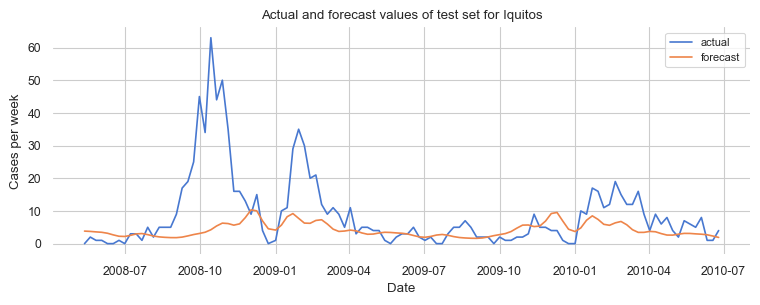

In [43]:
# Graph with back-transformed data
my_func.graph_actual_and_forecast_from_test(clean, str.title(this_run_city))

In [44]:
my_func.score(this_run_approach, this_run_variation, 
              this_run_details, this_run_city, this_run_data_set, this_run_transform, 
              clean['actual'], clean['forecast'], score_df)

In [45]:
score_df.tail(1)

,approach,variation,summary,city,data,transform,rmse,mae
33,additive,6,stabilized trend,iquitos,test,log(x+1),11.724512,6.519297


## Summarize - all models from this notebook - Iquitos

In [46]:
score_df[(score_df['approach'] == 'additive') &  (score_df['city'] == 'iquitos')].sort_values('mae')

,approach,variation,summary,city,data,transform,rmse,mae
33,additive,6,stabilized trend,iquitos,test,log(x+1),11.724512,6.519297


## Summarize - all models - San Juan

In [47]:
summary = score_df[(score_df['data'] == 'test') & (score_df['city'] == 'san juan')] 
summary.sort_values(by=['city', 'mae'], ascending=[False, True])

,approach,variation,summary,city,data,transform,rmse,mae
31,additive,4,stabilized trend,san juan,test,log(x+1),28.704714,14.594313
32,additive,5,cap and floor,san juan,test,log(x+1),29.944419,14.636217
25,exponential smoothing,10,"seasonalES, a=.5, b=.1, g=0, optimized",san juan,test,lox(x+1),26.543950,15.536584
13,ARIMA,2,"SARIMAX (2, 1, 2) x (2, 0, 1, 52)",san juan,test,log(x+1),26.606072,15.849436
24,exponential smoothing,9,"seasonalES, a=.9, b=.8, g=.1, optimized",san juan,test,none,28.602235,17.138453
12,ARIMA,1,"SARMIA (3, 1, 2) x (0, 0, 0, 52)",san juan,test,none,29.482909,18.707521
19,exponential smoothing,4,"simpleES, a=0",san juan,test,none,34.123644,19.089744
29,additive,2,stabilized trend,san juan,test,none,29.200444,20.051671
4,naive,3,seasonal naive method,san juan,test,none,35.954565,21.337607
30,additive,3,cap and floor,san juan,test,none,30.865402,23.434221


## Summarize - all models - Iquitos

In [48]:
summary = score_df[(score_df['data'] == 'test') & (score_df['city'] == 'iquitos')] 
summary.sort_values(by=['city', 'mae'], ascending=[False, True])

,approach,variation,summary,city,data,transform,rmse,mae
33,additive,6,stabilized trend,iquitos,test,log(x+1),11.724512,6.519297
15,ARIMA,4,"SARMIAX (1, 0, 1) x (0, 0, 0, 52)",iquitos,test,log(x+1),11.954236,6.764148
14,ARIMA,3,"SARMIAX (1, 0, 4) x (2, 0, 0, 52)",iquitos,test,none,11.023207,7.021882
6,naive,4,average method,iquitos,test,none,11.261033,7.647914
27,exponential smoothing,12,"seasonalES, a=.4, b=.4, g=.2, optimized",iquitos,test,log(x+1),12.989226,7.853348
26,exponential smoothing,11,"seasonalES, a=.6, b=0, g=0, optimized",iquitos,test,none,12.825165,8.147400
8,naive,5,naive method,iquitos,test,none,13.791890,8.162162
10,naive,6,seasonal naive method,iquitos,test,none,16.476847,9.918919


## Save scores

In [49]:
score_df.to_pickle('../sb_cap2_nb-99_data/scores_after_nbk_8.pickle')

## Commentary

In this notebook, I use Facebook's Prophet, an open-source forecasting tool.  This tool uses an additive regression model that separately models trend, models seasonality on yearly, monthly, weekly and even daily levels and models holidays.  

Generally, the tool is easy to use, following a standard instantiate, fit, forecast, graph and score process and including key helper functions.  However, the tool is a bit of "black box" approach.  It seems more focused on presenting forecasts than explaining the model producing them.  For example, the tool delivers clean visualizations but no summaries of the fit model's parameters and coefficients.

First, I examine the San Juan data using a number of different arguments.

* **Default**. To start, I create a baseline forecast with out-of-the box defaults.  Plus, I turned weekly and daily seasonality off as we've got weekly data.  Also, I did not enable holidays as we're dealing with medical, not consumer, behaviors.  While the baseline model does not score well, it nicely captures seasonality from month to month.  A problem might be an overestimation of the downward trend, even predicting negative values for weekly cases.

* **Stable trend**.  Next, I stabilize the trend.  To do so, I adjust a parameter for how responsive or "flexible" the trend is to changes.  And I reduce the number of "changepoints" or times the trend changes direction.  The results are a gradually declining trend as well as an improved score.  However, the forecast still predicts negative cases.

* **Cap and Floor**. Prophet has an options to put a floor (along with a cap) in a forecast.  To enable this feature, I need to switch to logistic-based growth model for the trend line.  With this enabled, the forecast does not include negatives; however, the score is not as good as the "stable trend" model.

* **Log-transformed data**.  My data has outliers--an occasional spike of an outbreak of cases.  To mitigate the impact of these outliers, I model off the log-transformed data sets.  Both the "stable trend" and the "cap and floor" models significantly improve when using log-transformed data.

After tuning my model on the San Juan data, I apply it to the Iquitos data.  And the model--stable trend on log-transformed data--performs best.

Overall, the results from Facebook's Prophet are the best performing ones to date.
